In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from models.test_lib import noiseLPF

# IDTxl libraries
from idtxl.bivariate_mi import BivariateMI
from idtxl.multivariate_mi import MultivariateMI
from idtxl.bivariate_te import BivariateTE
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


## 1. Load Neuronal Data

The neuronal data for a given experiment is given by the 3D matrix of dimensions `[N_Trial, N_Times, N_Channels]`

Notes:
* `DT = 0.05` : the sampling interval is always 50ms
* `N_Times = 201` : the total experiment time is always 10s. All experiments are aligned

In [2]:
# Declare constants
params = {
    "exp_timestep" : 0.05, # 50ms, the standard measurement interval
    "bin_timestep" : 0.2,  # 200ms, the binned interval
    
    # The standard timesteps for different scenarios
    "range_CUE" : (1.0, 1.5),    # 1-1.5 seconds trial time
    "range_TEX" : (2.0, 3.5),    # 2-3.5 seconds trial time
    "range_LIK" : (3.5, 6.0),    # 3.5-6 seconds trial time
    "range_ALL" : (0.0, 10.0),   # 0-10  seconds

#     "samples_window" : "ALL",
#     "trials_type"    : "GO",
    "subsampling"    : True,   # To bin or not to bin data
#     "subsampling_windows_lenghts" : 4*np.ones((1,51)),  #uniform subsampling, 50 bins
    
    "te_delay_min" : 1,
    "te_delay_max" : 6,
    
#     "te_delay_stepsize" : 1,
#     "te_receiver_embedding_tau" : 1,
#     "te_sampling_rate" : 20
}

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_15/mtp_15_2018_05_16_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (338, 201, 12)
50
Downsampling from 0.05 ms to 0.2 ms


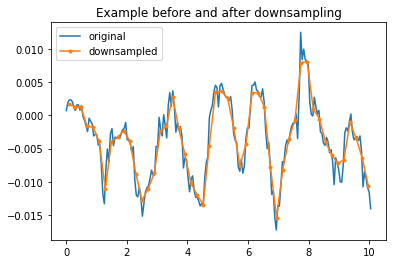

After downsampling data shape is (nTrials, nTimes, nChannels)= (338, 50, 12)


In [3]:
# Read LVM file from command line
#folderName = "mtp_1_2015_06_18_b"
folderName = "mtp_15_2018_05_16_a"
folderPath = "/mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_15"
data, behaviour = read_mat(os.path.join(folderPath, folderName))

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

assert nTimes == 201, "The number of timesteps must be 201 for all data, got "+str(nTimes)
nTimesDownsampled = int(nTimes * params["exp_timestep"] / params["bin_timestep"])
print(nTimesDownsampled)

# Timeline (x-axis)
tlst = params["exp_timestep"] * np.linspace(0, nTimes, nTimes)

# Downsample data
print("Downsampling from", params["exp_timestep"], "ms to", params["bin_timestep"], "ms")
if params["subsampling"]:
    params["timestep"] = params["bin_timestep"]
    tlst_new = downsample(tlst, data[0, :, 0], nTimesDownsampled)[0]
    data_new = np.array([[downsample(tlst, data[i, :, j], nTimesDownsampled)[1] 
                          for i in range(nTrials)] 
                         for j in range(nChannels)])
else:
    params["timestep"] = params["exp_timestep"]
    
# Plot downsampling for comparison
plt.figure()
plt.plot(tlst, data[0, :, 0], label='original')
plt.plot(tlst_new, data_new[0, 0, :], '.-', label='downsampled')
plt.title("Example before and after downsampling")
plt.legend()
plt.show()

# Replace old data with subsampled one    
tlst, data = tlst_new, data_new.transpose(1, 2, 0)
nTrials, nTimes, nChannels = data.shape
print("After downsampling data shape is (nTrials, nTimes, nChannels)=", data.shape)

# 2. Explore

Plot some time-traces and correlations to convince ourselves that the data makes sense

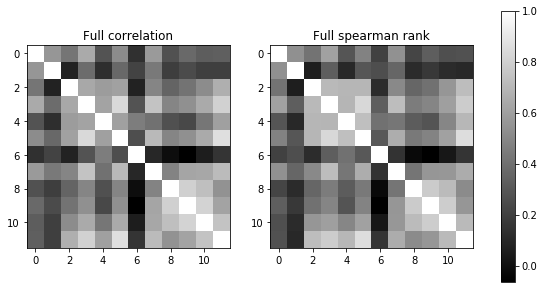

In [4]:
# Flatten and compute correlation matrix
flatData = np.array([data[:,:,i].flatten() for i in range(nChannels)])
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
im1 = ax[0].imshow(np.corrcoef(flatData), cmap="gray")
im2 = ax[1].imshow(sprMat(flatData), cmap="gray")
ax[0].set_title("Full correlation")
ax[1].set_title("Full spearman rank")
fig.colorbar(im1, ax=ax, orientation='vertical')
plt.show()

For window of 1.0 consider 5 point correlation over 338 trials


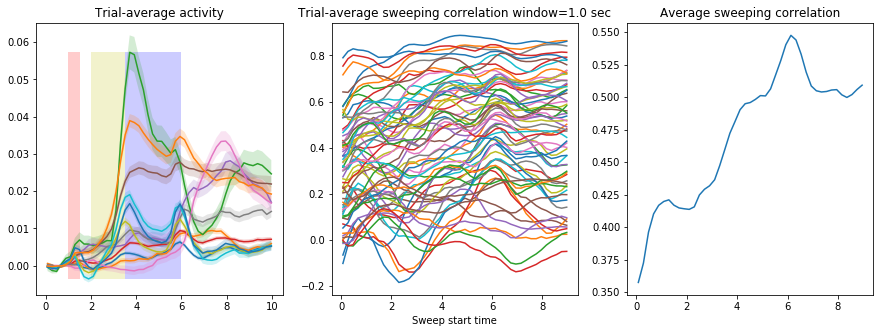

interactive(children=(IntSlider(value=22, description='i', max=44), Output(layout=Layout(height='350px'))), _d…

In [5]:
# Compute windowed correlation
windowsize_T = 1.0 # Seconds
windowsize = int(windowsize_T / params["timestep"])
print("For window of", windowsize_T, "consider", windowsize, "point correlation over", nTrials, "trials")
corrWindowed = np.zeros((nTimes-windowsize, nChannels, nChannels))
nOverlap = nTimes-windowsize

for j in range(nOverlap):
    flatData = np.array([data[:,j:j+windowsize,i].flatten() for i in range(nChannels)])
    corrWindowed[j] = np.corrcoef(flatData)


fig, ax = plt.subplots(ncols=3, figsize=(15,5))

# Plot mean and variance
ax[0].set_title("Trial-average activity")
act_lst = [np.mean(data[:,:,i], axis=0) for i in range(nChannels)]
err_lst = [np.std(data[:,:,i], axis=0, ddof=1) / np.sqrt(nTrials) for i in range(nChannels)]

# Fill in bars for the cue, lick and texture times
act_range = (np.min(act_lst), np.max(act_lst))
ax[0].fill_betweenx(act_range, params["range_CUE"][0], params["range_CUE"][1], alpha=0.2, color='r', linewidth=0.0)
ax[0].fill_betweenx(act_range, params["range_TEX"][0], params["range_TEX"][1], alpha=0.2, color='y', linewidth=0.0)
ax[0].fill_betweenx(act_range, params["range_LIK"][0], params["range_LIK"][1], alpha=0.2, color='b', linewidth=0.0)

for act, err in zip(act_lst, err_lst):
    ax[0].plot(tlst, act)
    ax[0].fill_between(tlst, act-err, act+err, alpha=0.2)

# Plot sweeping correlation
ax[1].set_title("Trial-average sweeping correlation window="+str(windowsize_T)+" sec")
ax[1].set_xlabel("Sweep start time")
for i in range(nChannels):
    for j in range(i+1, nChannels):
        ax[1].plot(tlst[:nOverlap], corrWindowed[:, i, j], label="["+str(i)+","+str(j)+"]")

ax[2].set_title("Average sweeping correlation")
ax[2].plot(tlst[:nOverlap], np.mean(corrWindowed, axis=(1,2)))
    
plt.show()

# Interactive
def f(i):
    plt.figure()
    plt.imshow(corrWindowed[i], cmap="gray")
    plt.colorbar()
    plt.show()
    
interactive_plot = interactive(f, i=(0, nTimes-windowsize-1, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

## 3. Transfer Entropy via IDTxl

Notation of IDTxl
* `(processes, samples, replications)` equivalent to ours `(channels, times, trials)`
* Thus Yaro matrix `(nTrials, nTimes, nChannels)` is given by `'rsp'`, but
* For example `(nChannels, nTimes)` would be `'ps'`

In [ ]:
# a) Convert data to ITDxl format
dataIDTxl = Data(data, dim_order='rsp')

net_analysis_lst = [BivariateTE(), MultivariateTE()]
methods_lst = ["BivariateTE", "MultivariateTE"]


settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': params["te_delay_max"],
            'min_lag_sources': params["te_delay_min"]}

# c) Run analysis
results_lst = [na.analyse_network(settings=settings, data=dataIDTxl) for na in net_analysis_lst]

# # d) Plot inferred network to console and via matplotlib
# results.print_edge_list(weights='max_te_lag', fdr=False)
# plot_network(results=results, weights='max_te_lag', fdr=False)
# plt.show()

# d) Convert results into comfortable form
results_mat_lst = [idtxlResults2matrix(rez, nChannels, method=method) for rez, method in zip(results_lst, methods_lst)]

#######################
# Plot Results
#######################

for rez_mat, method in zip(results_mat_lst, methods_lst):
    plotImshowMat(
        rez_mat,
        [method, "Delays", "p-value"],
        'IDTxl analysis of ' + folderName,
        (1, 3),
        lims = [[0, 1], [0, params["te_delay_max"]], [0, 1]],
        draw = True,
        savename = folderName + '_' + method + '.png'
    )

plt.show()

Adding data with properties: 12 processes, 50 samples, 338 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing ca

testing candidate: (9, 3) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(1, 1), (1, 5), (2, 0), (2, 5), (2, 4), (2, 3), (3, 5), (3, 4), (3, 0), (3, 3), (4, 0), (5, 5), (5, 4), (5, 0), (6, 2), (6, 5), (6, 0), (7, 5), (7, 4), (7, 1), (8, 0), (8, 3), (8, 5), (8, 4), (9, 0), (9, 3), (9, 5), (9, 4), (10, 0), (10, 3), (10, 5), (10, 4), (11, 0), (11, 5), (11, 4)]
selected candidates current source: [(10, 6), (10, 3), (10, 1), (10, 2)]
testing candidate: (10, 3) minimum statistic, n_perm: 500
testing candidate: (10, 6) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(1, 1), (1, 5), (2, 0), (2, 5), (2, 4), (2, 3), (3, 5), (3, 4), (3, 0), (3, 3), (4, 0), (5, 5), (5, 4), (5, 0), (6, 2), (6, 5), (6, 0), (7, 5), (7, 4), (7, 1), (8, 0), (8, 3), (8, 5), (8, 4), (9, 0), (9, 3), (9, 5), (9, 4), (10, 0), (10, 5), (10, 4), (11, 0), (11, 5), (11, 4)]
selected candidates current source: [(11, 6), (11, 1), (11, 2)]
testing candidate: (11, 6) minimum statistic, n

 -- significant
selected vars sources [(0, 5), (0, 3), (0, 0), (2, 0), (2, 1), (3, 5), (3, 4), (3, 0), (3, 3), (4, 0), (4, 3), (4, 5), (4, 4), (5, 0), (5, 2), (5, 5), (5, 4), (6, 1), (6, 0), (7, 3), (7, 0), (8, 0), (9, 0), (10, 0), (10, 2), (10, 5), (10, 4), (11, 0), (11, 2)]
selected candidates current source: [(7, 3), (7, 6)]
testing candidate: (7, 6) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 5), (0, 3), (0, 0), (2, 0), (2, 1), (3, 5), (3, 4), (3, 0), (3, 3), (4, 0), (4, 3), (4, 5), (4, 4), (5, 0), (5, 2), (5, 5), (5, 4), (6, 1), (6, 0), (7, 3), (7, 0), (8, 0), (9, 0), (10, 0), (10, 2), (10, 5), (10, 4), (11, 0), (11, 2)]
selected candidates current source: [(8, 6)]
 -- significant
selected vars sources [(0, 5), (0, 3), (0, 0), (2, 0), (2, 1), (3, 5), (3, 4), (3, 0), (3, 3), (4, 0), (4, 3), (4, 5), (4, 4), (5, 0), (5, 2), (5, 5), (5, 4), (6, 1), (6, 0), (7, 3), (7, 0), (8, 0), (9, 0), (10, 0), (10, 2), (10, 5), (10, 4), (11, 0), (11, 2)]
selected candi

testing candidate: (7, 6) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(1, 5), (1, 2), (1, 4), (1, 3), (1, 0), (3, 5), (3, 3), (4, 5), (5, 5), (5, 4), (5, 2), (6, 5), (6, 2), (7, 5), (7, 4), (7, 0), (8, 5), (8, 3), (9, 5), (9, 4), (10, 5), (10, 4), (11, 5), (11, 4)]
selected candidates current source: [(8, 1), (8, 3)]
testing candidate: (8, 3) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(1, 5), (1, 2), (1, 4), (1, 3), (1, 0), (3, 5), (3, 3), (4, 5), (5, 5), (5, 4), (5, 2), (6, 5), (6, 2), (7, 5), (7, 4), (7, 0), (8, 5), (8, 3), (9, 5), (9, 4), (10, 5), (10, 4), (11, 5), (11, 4)]
selected candidates current source: [(9, 1), (9, 2)]
testing candidate: (9, 2) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(1, 5), (1, 2), (1, 4), (1, 3), (1, 0), (3, 5), (3, 3), (4, 5), (5, 5), (5, 4), (5, 2), (6, 5), (6, 2), (7, 5), (7, 4), (7, 0), (8, 5), (8, 3), (9, 5), (9, 4), (10, 5), (10, 4), (11, 5), (11, 4)]
selected candidate

testing candidate: (7, 4) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 2), (0, 5), (0, 4), (0, 3), (1, 1), (2, 5), (2, 4), (2, 1), (4, 5), (4, 4), (5, 5), (5, 4), (7, 5), (7, 4), (7, 2), (8, 3), (8, 5), (8, 4), (8, 0), (9, 5), (9, 4), (9, 0), (9, 2), (9, 1), (10, 5), (10, 4), (10, 0), (11, 5), (11, 4), (11, 1)]
selected candidates current source: [(8, 3), (8, 1), (8, 2), (8, 6)]
testing candidate: (8, 3) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 2), (0, 5), (0, 4), (0, 3), (1, 1), (2, 5), (2, 4), (2, 1), (4, 5), (4, 4), (5, 5), (5, 4), (7, 5), (7, 4), (7, 2), (8, 3), (8, 5), (8, 4), (8, 0), (9, 5), (9, 4), (9, 0), (9, 2), (9, 1), (10, 5), (10, 4), (10, 0), (11, 5), (11, 4), (11, 1)]
selected candidates current source: [(9, 1), (9, 2), (9, 6), (9, 4), (9, 5)]
testing candidate: (9, 6) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 2), (0, 5), (0, 4), (0, 3), (1, 1), (2, 5), (2, 4), (2, 1), (4, 5), (4

testing candidate: (5, 4) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 5), (0, 4), (1, 5), (1, 2), (2, 5), (2, 4), (2, 3), (3, 5), (3, 4), (3, 0), (5, 5), (5, 4), (5, 2), (6, 5), (6, 0), (6, 4), (6, 3), (7, 5), (7, 4), (7, 2), (8, 5), (8, 3), (9, 5), (9, 4), (10, 5), (10, 4), (11, 5), (11, 4)]
selected candidates current source: [(6, 1), (6, 6), (6, 2), (6, 3)]
testing candidate: (6, 6) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 5), (0, 4), (1, 5), (1, 2), (2, 5), (2, 4), (2, 3), (3, 5), (3, 4), (3, 0), (5, 5), (5, 4), (5, 2), (6, 5), (6, 0), (6, 4), (6, 3), (7, 5), (7, 4), (7, 2), (8, 5), (8, 3), (9, 5), (9, 4), (10, 5), (10, 4), (11, 5), (11, 4)]
selected candidates current source: [(7, 1), (7, 2), (7, 4)]
testing candidate: (7, 4) minimum statistic, n_perm: 500
 -- significant
selected vars sources [(0, 5), (0, 4), (1, 5), (1, 2), (2, 5), (2, 4), (2, 3), (3, 5), (3, 4), (3, 0), (5, 5), (5, 4), (5, 2), (6, 5), (6, 0), (6, 4)